In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split 
import os
import copy
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from math import sqrt
from itertools import product as product
import torchvision
from torchvision.ops import nms
import random
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Config:
    classes = ['background', 'RBC', 'WBC', 'Platelets']
    num_classes = len(classes)
    input_size = 300
    batch_size = 8
    num_workers = 4
    lr = 1e-3
    weight_decay = 5e-4
    num_epochs = 30
    detection_threshold = 0.5

def collate_fn(batch):
    images = []
    boxes = []
    labels = []
    
    for b in batch:
        images.append(b[0])  # image tensor
        boxes.append(b[1])   # boxes tensor
        labels.append(b[2])  # labels tensor
    
    images = torch.stack(images, dim=0)
    
    return images, boxes, labels

class BCCDDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_dir = os.path.join(root, 'JPEGImages')
        self.annotation_dir = os.path.join(root, 'Annotations')
        self.image_files = [f for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        annotation_path = os.path.join(self.annotation_dir, img_name.replace('.jpg', '.xml'))
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Парсинг аннотаций
        boxes, labels = self.parse_xml(annotation_path)
        
        if self.transform:
            image, boxes, labels = self.transform(image, boxes, labels)
            
        return image, boxes, labels
    
    def parse_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        boxes = []
        labels = []
        
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            labels.append(Config.classes.index(class_name))
            
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
        
        return torch.FloatTensor(boxes), torch.LongTensor(labels)

In [3]:
class ResizeNormalize(object):
    def __init__(self, size=300):
        self.size = size
        
    def __call__(self, image, boxes, labels):
        h, w = image.shape[:2]
        image = cv2.resize(image, (self.size, self.size))
        
        # Масштабируем bounding boxes
        boxes[:, [0, 2]] /= w
        boxes[:, [1, 3]] /= h
        
        # Normalize
        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])(image)
        
        return image, boxes, labels


In [4]:
def prepare_datasets(root_dir):
    full_dataset = BCCDDataset(root=root_dir, transform=ResizeNormalize(300))
    
    # Сначала разделим на train+val и test
    train_val_indices, test_indices = train_test_split(
        range(len(full_dataset)), test_size=0.2, random_state=42)
    
    # Затем разделим train+val на train и val
    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=0.1, random_state=42)
    
    # Создаем поднаборы
    train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
    test_dataset = torch.utils.data.Subset(full_dataset, test_indices)
    
    return train_dataset, val_dataset, test_dataset

In [5]:
def decimate(tensor, m):
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d,
                                        index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())
    return tensor

In [6]:
class VGGBase(nn.Module):
    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # retains size because stride is 1 (and padding)

        # Replacements for FC6 and FC7 in VGG16
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        out = F.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = F.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)

        out = F.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = F.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)

        out = F.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(out)  # (N, 256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # (N, 512, 38, 38)
        out = self.pool4(out)  # (N, 512, 19, 19)

        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))  # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        self.load_state_dict(state_dict)

        print("\nLoaded base model.\n")


In [7]:
class AuxiliaryConvolutions(nn.Module):
    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1) 

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  

        self.init_conv2d()

    def init_conv2d(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv7_feats):

        out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
        out = F.relu(self.conv8_2(out))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = F.relu(self.conv9_1(out))  # (N, 128, 10, 10)
        out = F.relu(self.conv9_2(out))  # (N, 256, 5, 5)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = F.relu(self.conv10_1(out))  # (N, 128, 5, 5)
        out = F.relu(self.conv10_2(out))  # (N, 256, 3, 3)
        conv10_2_feats = out  # (N, 256, 3, 3)

        out = F.relu(self.conv11_1(out))  # (N, 128, 3, 3)
        conv11_2_feats = F.relu(self.conv11_2(out))  # (N, 256, 1, 1)

        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats

In [8]:
class PredictionConvolutions(nn.Module):
    def __init__(self, n_classes):
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}

        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)

        self.init_conv2d()

    def init_conv2d(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        batch_size = conv4_3_feats.size(0)

        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 16)
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)  # (N, 5776, 4)

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(batch_size, -1, 4)  # (N, 2166, 4)

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 16)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  # (N, 4, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 4 * n_classes)
        c_conv4_3 = c_conv4_3.view(batch_size, -1,
                                   self.n_classes)  # (N, 5776, n_classes)

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1,
                               self.n_classes)  # (N, 2166, n_classes)

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 4 * n_classes)
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  # (N, 4, n_classes)

        # A total of 8732 boxes
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2],
                                   dim=1)  # (N, 8732, n_classes)

        return locs, classes_scores

In [9]:
class SSD300(nn.Module):
    def __init__(self, n_classes):
        super(SSD300, self).__init__()
        
        self.n_classes = n_classes
        
        self.base = VGGBase()
        
        # Auxiliary convolutions
        self.aux_convs = AuxiliaryConvolutions()
        
        # Prediction convolutions
        self.pred_convs = PredictionConvolutions(n_classes)
        
        # Rescale factor for conv4_3
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))
        nn.init.constant_(self.rescale_factors, 20)
        
        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()
        
    def forward(self, image):
        # Forward pass through base network
        conv4_3_feats, conv7_feats = self.base(image)
        
        # Rescale conv4_3 after L2 normalization
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()
        conv4_3_feats = conv4_3_feats / norm
        conv4_3_feats = conv4_3_feats * self.rescale_factors
        
        # Forward pass through auxiliary convolutions
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = self.aux_convs(conv7_feats)
        
        # Forward pass through prediction convolutions
        locs, class_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, 
                                           conv9_2_feats, conv10_2_feats, conv11_2_feats)
        
        return locs, class_scores
    
    def create_prior_boxes(self):
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())
        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])
                        
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)
        prior_boxes.clamp_(0, 1)
        
        return prior_boxes
    
    def detect_objects(self, predicted_locs, predicted_scores, min_score=0.2, max_overlap=0.45, top_k=200):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)
        
        all_images_boxes = []
        all_images_labels = []
        all_images_scores = []

        for i in range(batch_size):
            # Decode locations from predictions
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))
            
            image_boxes = []
            image_labels = []
            image_scores = []
            
            # Check for each class (skip background)
            for c in range(1, self.n_classes):
                class_scores = predicted_scores[i][:, c]
                score_above_min_score = class_scores > min_score
                n_above_min_score = score_above_min_score.sum().item()
                
                if n_above_min_score == 0:
                    continue
                    
                class_scores = class_scores[score_above_min_score]
                class_decoded_locs = decoded_locs[score_above_min_score]
                
                # Sort by score
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)
                class_decoded_locs = class_decoded_locs[sort_ind]
                
                # Non-maximum suppression
                keep = nms(class_decoded_locs, class_scores, max_overlap)
                
                # Store results
                image_boxes.append(class_decoded_locs[keep])
                image_labels.append(torch.LongTensor(keep.size(0)).fill_(c).to(device))
                image_scores.append(class_scores[keep])
            
            # If no objects found, add background
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))
                
            # Concatenate results
            image_boxes = torch.cat(image_boxes, dim=0)
            image_labels = torch.cat(image_labels, dim=0)
            image_scores = torch.cat(image_scores, dim=0)
            
            # Keep only top k
            if image_scores.size(0) > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]
                image_boxes = image_boxes[sort_ind][:top_k]
                image_labels = image_labels[sort_ind][:top_k]
                
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)
            
        return all_images_boxes, all_images_labels, all_images_scores

def cxcy_to_xy(cxcy):
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # xmin, ymin
                     cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # xmax, ymax

def xy_to_cxcy(xy):
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # cx, cy
                     xy[:, 2:] - xy[:, :2]], 1)  # w, h

def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # cx, cy
                     torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)  # w, h

def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    return torch.cat([10 * (cxcy[:, :2] - priors_cxcy[:, :2]) / priors_cxcy[:, 2:],  # gcx, gcy
                     5 * torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:])], 1)  # gw, gh

In [10]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=30):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            
            for images, boxes, labels in dataloaders[phase]:
                images = images.to(device)
                boxes = [b.to(device) for b in boxes]
                labels = [l.to(device) for l in labels]
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    predicted_locs, predicted_scores = model(images)
                    loss = criterion(predicted_locs, predicted_scores, boxes, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * images.size(0)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f}')
            
            if phase == 'val':
                scheduler.step(epoch_loss)
            
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
    
    print(f'Best val Loss: {best_loss:.4f}')
    model.load_state_dict(best_model_wts)
    return model



In [11]:
def visualize_predictions(image, boxes, labels, scores, gt_boxes=None, gt_labels=None, threshold=0.5):
    h, w = image.shape[:2]
    
    left_image = image.copy()
    right_image = image.copy()
    
    if gt_boxes is not None and gt_labels is not None:
        gt_boxes = gt_boxes.cpu().numpy()
        gt_labels = gt_labels.cpu().numpy()
        
        for box, label in zip(gt_boxes, gt_labels):
            box = box * np.array([w, h, w, h])
            xmin, ymin, xmax, ymax = box.astype(int)
            
            cv2.rectangle(left_image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            text = f"GT: {Config.classes[label]}"
            cv2.putText(left_image, text, (xmin, ymin-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    boxes = boxes.cpu().numpy()
    labels = labels.cpu().numpy()
    scores = scores.cpu().numpy()
    
    for box, label, score in zip(boxes, labels, scores):
        if score < threshold or label == 0:
            continue
            
        box = box * np.array([w, h, w, h])
        xmin, ymin, xmax, ymax = box.astype(int)
        
        cv2.rectangle(right_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        text = f"{Config.classes[label]}: {score:.2f}"
        cv2.putText(right_image, text, (xmin, ymin-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(left_image)
    plt.title('Ground Truth')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(right_image)
    plt.title('Predictions')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def evaluate_map(det_boxes, det_labels, det_scores, gt_boxes, gt_labels, classes, iou_threshold=0.5):
    classes = classes[1:]
    n_classes = len(classes)
    
    true_positives = [[] for _ in range(n_classes)]
    false_positives = [[] for _ in range(n_classes)]
    scores = [[] for _ in range(n_classes)]
    n_ground_truth = [0] * n_classes
    
    for img_boxes, img_labels, img_scores, img_gt_boxes, img_gt_labels in zip(
            det_boxes, det_labels, det_scores, gt_boxes, gt_labels):
        
        # Для каждого класса
        for c in range(n_classes):
            class_mask = (img_labels == c+1)  # +1 потому что 0 - это background
            class_boxes = img_boxes[class_mask]
            class_scores = img_scores[class_mask]
            
            sorted_ind = torch.argsort(class_scores, descending=True)
            class_boxes = class_boxes[sorted_ind]
            class_scores = class_scores[sorted_ind]
            

            gt_mask = (img_gt_labels == c+1)
            gt_boxes_class = img_gt_boxes[gt_mask]
            n_ground_truth[c] += len(gt_boxes_class)
            
            # Для каждой детекции находим максимальное IoU с ground truth
            detected = [False] * len(gt_boxes_class)
            for box, score in zip(class_boxes, class_scores):
                max_iou = 0
                best_gt_idx = -1
                
                for gt_idx, gt_box in enumerate(gt_boxes_class):
                    iou = find_jaccard_overlap(box.unsqueeze(0), gt_box.unsqueeze(0)).item()
                    if iou > max_iou:
                        max_iou = iou
                        best_gt_idx = gt_idx
                
                # Если IoU > порога и этот ground truth еще не обнаружен
                if max_iou > iou_threshold and best_gt_idx != -1 and not detected[best_gt_idx]:
                    true_positives[c].append(1)
                    false_positives[c].append(0)
                    detected[best_gt_idx] = True
                else:
                    true_positives[c].append(0)
                    false_positives[c].append(1)
                
                scores[c].append(score.item())
    
    # Вычисляем Average Precision для каждого класса
    average_precisions = []
    
    for c in range(n_classes):
        if n_ground_truth[c] == 0:
            continue
            
        tp = np.array(true_positives[c])
        fp = np.array(false_positives[c])
        sc = np.array(scores[c])
        
        sorted_ind = np.argsort(-sc)
        tp = tp[sorted_ind]
        fp = fp[sorted_ind]
        
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        
        # Recall и Precision
        recall = tp_cumsum / n_ground_truth[c]
        precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-10)
        
        ap = 0
        for t in np.arange(0, 1.1, 0.1):
            mask = recall >= t
            if np.any(mask):
                p = np.max(precision[mask])
            else:
                p = 0
            ap += p / 11
        
        average_precisions.append(ap)
        print(f"Class '{classes[c]}' AP: {ap:.4f}")
    
    mean_ap = np.mean(average_precisions)
    return mean_ap

def find_jaccard_overlap(boxes1, boxes2):
    inter_xmin = torch.max(boxes1[:, 0].unsqueeze(1), boxes2[:, 0].unsqueeze(0))
    inter_ymin = torch.max(boxes1[:, 1].unsqueeze(1), boxes2[:, 1].unsqueeze(0))
    inter_xmax = torch.min(boxes1[:, 2].unsqueeze(1), boxes2[:, 2].unsqueeze(0))
    inter_ymax = torch.min(boxes1[:, 3].unsqueeze(1), boxes2[:, 3].unsqueeze(0))
    
    inter_width = (inter_xmax - inter_xmin).clamp(min=0)
    inter_height = (inter_ymax - inter_ymin).clamp(min=0)
    inter_area = inter_width * inter_height
    
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    union_area = area1.unsqueeze(1) + area2.unsqueeze(0) - inter_area
    
    return inter_area / union_area

In [12]:
class MultiBoxLoss(nn.Module):
    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()  # *smooth* L1 loss in the paper; see Remarks section in the tutorial
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):

        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)


            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            overlap_for_each_prior[prior_for_each_object] = 1.

            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            true_classes[i] = label_for_each_prior

            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732)
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss

In [13]:
def main():
    Config = {
        'classes': ['background', 'RBC', 'WBC', 'Platelets'],
        'batch_size': 2,
        'lr': 1e-3,
        'weight_decay': 5e-4,
        'num_epochs': 50,
        'detection_threshold': 0.5,
        'data_root': 'BCCD_Dataset'
    }
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    print("\n1. Preparing datasets...")

    train_dataset, val_dataset, test_dataset = prepare_datasets(Config['data_root'])

    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=Config['batch_size'],
                            shuffle=True,
                            collate_fn=collate_fn, pin_memory=True),
        'val': DataLoader(val_dataset, batch_size=Config['batch_size'],
                        shuffle=False,
                        collate_fn=collate_fn, pin_memory=True),
        'test': DataLoader(test_dataset, batch_size=1,
                            shuffle=False,
                            collate_fn=collate_fn)
    }
    print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    
    print("\n2. Initializing model...")
    model = SSD300(n_classes=4).to(device)
    optimizer = Adam(model.parameters(), lr=Config['lr'], 
                    weight_decay=Config['weight_decay'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                patience=5, verbose=True)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    print("\n3. Starting training...")
    model = train_model(
        model=model,
        dataloaders=dataloaders,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=Config['num_epochs']
    )

    print("\n4. Saving model...")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'config': Config
    }, 'ssd300_bccd.pth')
    print("Model successfully saved to 'ssd300_bccd.pth'")

    print("\n5. Evaluating model...")
    test_results = {
        'boxes': [],
        'labels': [],
        'scores': [],
        'gt_boxes': [],
        'gt_labels': []
    }
        
    test_loss = 0.0
    model.eval()
        
    with torch.no_grad():
        for i, (images, boxes, labels) in enumerate(dataloaders['test']):
            images = images.to(device)
            gt_boxes = [b.to(device) for b in boxes]
            gt_labels = [l.to(device) for l in labels]
            
            predicted_locs, predicted_scores = model(images)
            
            loss = criterion(predicted_locs, predicted_scores, gt_boxes, gt_labels)
            test_loss += loss.item() * images.size(0)
            
            det_boxes, det_labels, det_scores = model.detect_objects(
                predicted_locs, predicted_scores, 
                min_score=Config['detection_threshold'], 
                max_overlap=0.45, top_k=200)
            
            test_results['boxes'].extend(det_boxes)
            test_results['labels'].extend(det_labels)
            test_results['scores'].extend(det_scores)
            test_results['gt_boxes'].extend(gt_boxes)
            test_results['gt_labels'].extend(gt_labels)
            
            if i < 5:
                print(f"\nVisualizing example {i+1}...")
                img_path = test_dataset.dataset.image_files[test_dataset.indices[i]]
                img_path = os.path.join(Config['data_root'], 'JPEGImages', img_path)
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    visualize_predictions(
                        image.copy(), 
                        det_boxes[0], 
                        det_labels[0], 
                        det_scores[0],
                        gt_boxes=boxes[0],  
                        gt_labels=labels[0], 
                        threshold=Config['detection_threshold']
                    )
                else:
                    print(f"Could not load image: {img_path}")

    test_loss = test_loss / len(dataloaders['test'].dataset)
    print(f"\nTest Loss: {test_loss:.4f}")
    
    # Вычисление mAP
    print("\nCalculating mAP...")
    mean_ap = evaluate_map(
        test_results['boxes'],
        test_results['labels'],
        test_results['scores'],
        test_results['gt_boxes'],
        test_results['gt_labels'],
        Config['classes']
    )
    print(f"Mean Average Precision (mAP): {mean_ap:.4f}")
        


    print("\nTraining and evaluation completed successfully!")

Может можно было и подольше поучить, но дедлайны горят... :c

К сожалению, все что успел :(


Using device: cuda

1. Preparing datasets...
Dataset sizes - Train: 261, Val: 30, Test: 73

2. Initializing model...


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Loaded base model.



c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



3. Starting training...
Epoch 0/49
----------
train Loss: inf
val Loss: 3.1594
Epoch 1/49
----------
train Loss: inf
val Loss: 3.0441
Epoch 2/49
----------
train Loss: inf
val Loss: 2.7511
Epoch 3/49
----------
train Loss: inf
val Loss: 2.4406
Epoch 4/49
----------
train Loss: inf
val Loss: 2.4412
Epoch 5/49
----------
train Loss: inf
val Loss: 2.3982
Epoch 6/49
----------
train Loss: inf
val Loss: 2.3270
Epoch 7/49
----------
train Loss: inf
val Loss: 2.2712
Epoch 8/49
----------
train Loss: inf
val Loss: 2.4083
Epoch 9/49
----------
train Loss: inf
val Loss: 2.2763
Epoch 10/49
----------
train Loss: inf
val Loss: 2.4102
Epoch 11/49
----------
train Loss: inf
val Loss: 2.2703
Epoch 12/49
----------
train Loss: inf
val Loss: 2.2802
Epoch 13/49
----------
train Loss: inf
val Loss: 2.2781
Epoch 14/49
----------
train Loss: inf
val Loss: 2.4157
Epoch 15/49
----------
train Loss: inf
val Loss: 2.2718
Epoch 16/49
----------
train Loss: inf
val Loss: 2.2185
Epoch 17/49
----------
train Loss

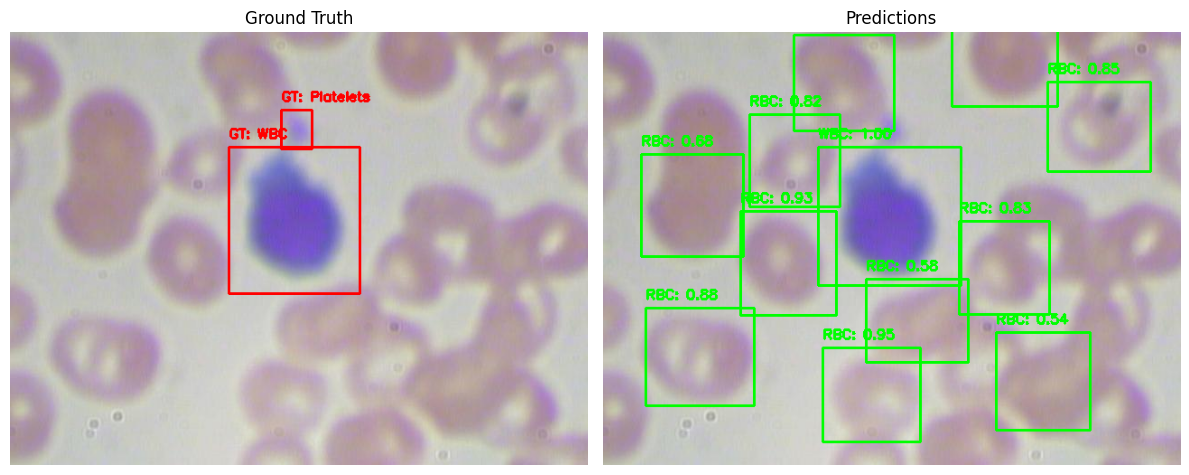


Visualizing example 2...


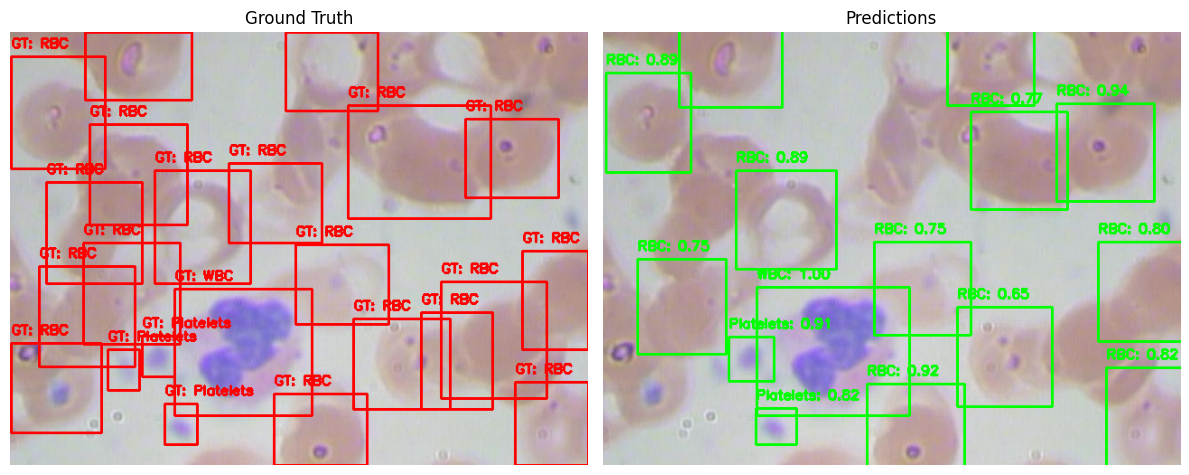


Visualizing example 3...


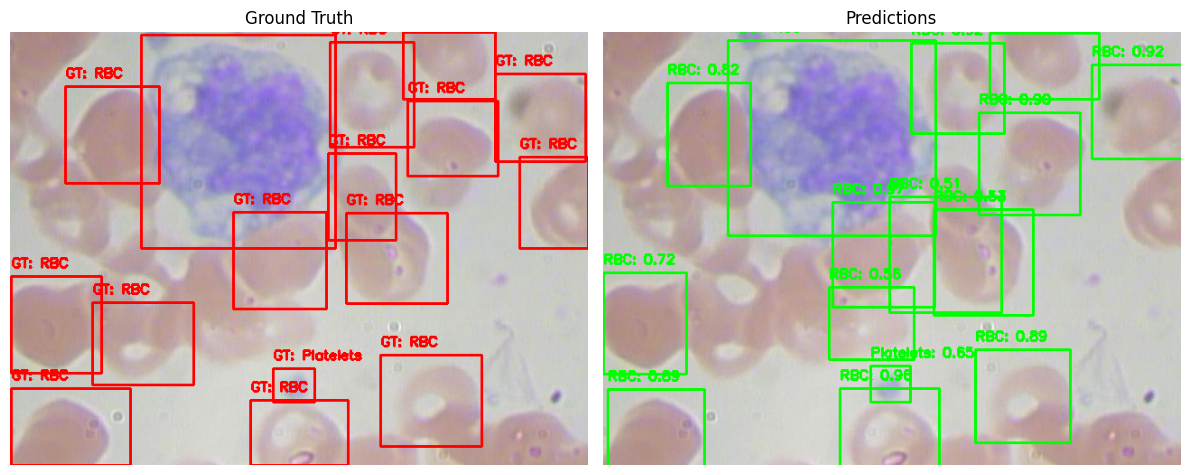


Visualizing example 4...


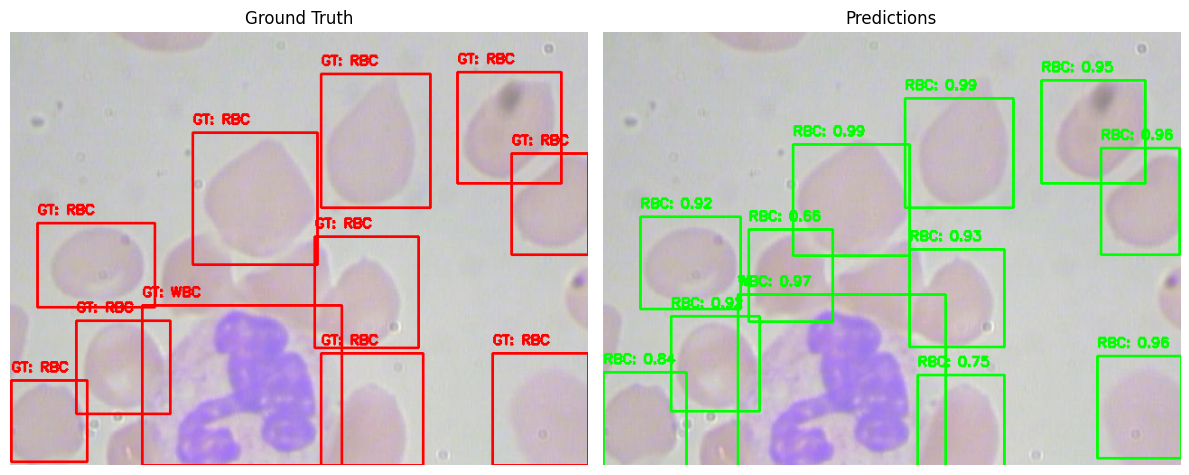


Visualizing example 5...


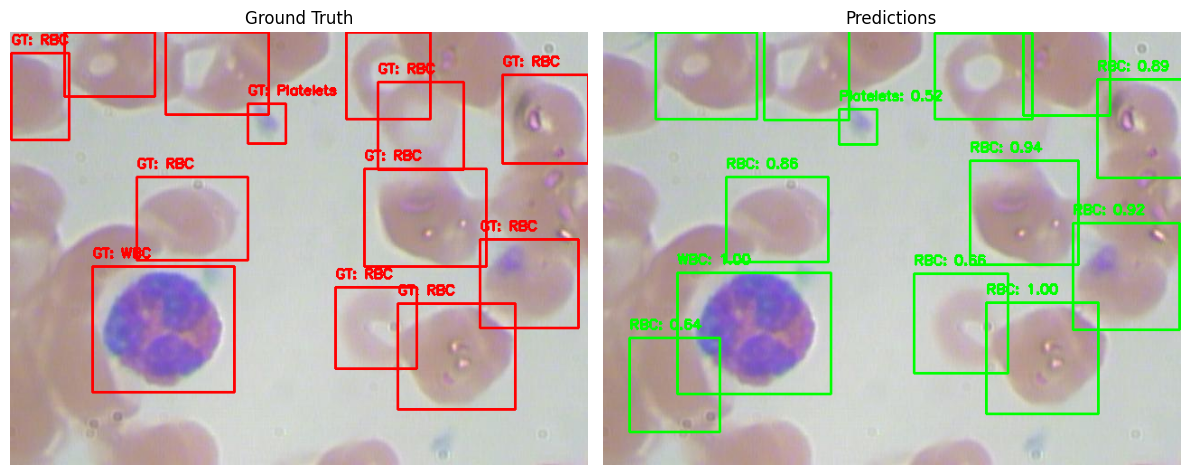


Test Loss: 2.5024

Calculating mAP...
Class 'RBC' AP: 0.6351
Class 'WBC' AP: 0.9066
Class 'Platelets' AP: 0.5093
Mean Average Precision (mAP): 0.6837

Training and evaluation completed successfully!


In [14]:
if __name__ == '__main__':
    main()

In [13]:
def detect(image_path, model_path='ssd300_bccd.pth', threshold=0.5):
    image = cv2.imread(image_path)
    
    # Определение классов (должно соответствовать обучению модели)
    classes = ['background', 'RBC', 'WBC', 'Platelets']
    
    # Инициализация модели
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SSD300(n_classes=len(classes)).to(device)
    
    # Загрузка весов модели
    checkpoint = torch.load(model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    model.eval()
    
    # Преобразование изображения
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (300, 300))
    img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])(img)
    img = img.unsqueeze(0).to(device)
    
    # Детекция объектов
    with torch.no_grad():
        locs, scores = model(img)
        boxes, labels, confidences = model.detect_objects(
            locs, scores,
            min_score=threshold,
            max_overlap=0.45,
            top_k=200
        )
    
    # Визуализация результатов
    h, w = image.shape[:2]
    for box, label, confidence in zip(boxes[0], labels[0], confidences[0]):
        if label == 0:  # Пропускаем background
            continue
            
        # Масштабирование координат
        box = (box.cpu().numpy() * [w, h, w, h]).astype(int)
        x1, y1, x2, y2 = box
        
        # Рисуем bounding box (все одного цвета)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Текст с классом и confidence
        text = f"{classes[label]}: {confidence:.2f}"
        cv2.putText(image, text, (x1, y1 - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    plt.imshow(image)
    return 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Loaded base model.



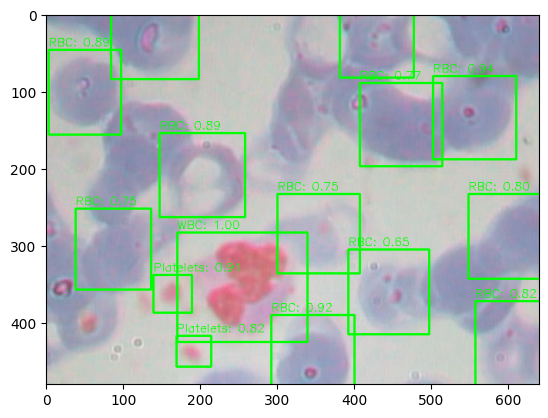

In [14]:
detect('BCCD_Dataset\\JPEGImages\\BloodImage_00035.jpg')